## Epidemiology model for spread of COVID-19
### Author: Dr Wladimir Lyra, New Mexico State University



In this code I will use a SIR (susceptible-infected-removed) model. The model traces the evolution of a susceptible population $S$, infected $I$, and removed population, $R$. The equations are


\begin{eqnarray}
\frac{dS}{dt} &=&-\beta \frac{I S}{N} \\
\frac{dI}{dt} &=& \beta \frac{I S}{N} - \gamma I \\
\frac{dR}{dt} &=&\gamma I
\end{eqnarray}

$\beta$ is the infection rate, and $\gamma$ is the recovery rate, and $\mu$ is the death rate. 

Contact with infected people removes a fraction of the susceptible population at the rate $\beta I S $, placing them at the infected population. At the same time, the infected population has a recovery rate $\gamma$. 

### The parameter $R_0$

We can gain understanding of the dynamics of the infected population by writing its equation as 

\begin{equation}
\frac{dI}{dt} = \gamma I \left(\frac{\beta}{\gamma} \frac{S}{N} - 1 \right),
\end{equation}

and noticing that in the beggining of the infection, when $S \approx N$ (where $N$ is the size of the population) it reduces to 

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(\frac{\beta}{\gamma}  - 1 \right).
\end{equation}

The dynamics of the infected population is controled by the parameter 

\begin{equation}
R_0 = \frac{\beta}{\gamma}
\end{equation}

When $R_0 > 1$ the infected population grows exponentially. When $R_0 \leq 1$ the disease is controlled. 

$R_0$ can be thought of as the average number of people an infected person will contaminate before being removed. As such, it is called the basic reproduction number. Social distancing has the effect of lowering the infection rate $\beta$, and thus the basic reproduction number $R_0$. 






### Doubling time and application to current COVID-19 epidemics

Based on  

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(R_0  - 1 \right)
\end{equation}

we can relate the doubling time of the infection to $R_0$. The e-folding time is 

\begin{equation}
t_e = \frac{1}{\gamma \left(R_0-1\right)}
\end{equation}

So the doubing time is 

\begin{equation}
t_{\rm double} = t_e \ \ln 2 = \frac{\ln 2}{\gamma \left(R_0-1\right)}
\end{equation}


In [1]:
import numpy as np
import pylab as plt
import sys 
#
gamma = 0.07

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes                   
plt.rc('axes', titlesize=MEDIUM_SIZE) # fontsize of the axes title               
plt.rc('axes', labelsize=BIGGER_SIZE) # fontsize of the x and y labels           
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize                         
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title         


The next blocks have funtion definitions

In [2]:
def date_to_time(d):
    from datetime import datetime    

    n=len(d)    
    
    date=np.zeros(n)
    for i in range(n):
        date_object = datetime.strptime(d[i], '%m/%d/%y')
        date[i] = datetime.fromisoformat(np.str(date_object)).timestamp()
                  
    return (date-date[n-1])/86400.                
    
    
def calc_doubling_time(time,cases):

    exponential_slope = np.gradient(np.log(1.0*cases+1e-10),time) 

    n=len(exponential_slope)
    doubling_time=np.zeros(n)
    for i in range(n):
        if (exponential_slope[i] != 0):
            doubling_time[i] = np.log(2.)/exponential_slope[i]
        else:
            doubling_time[i]=0.0
    
    return doubling_time

def read_jhu_data(country,mode):
    import csv
    base='./dat/time_series_19-covid-' 
    with open(base+mode+'.csv', newline='') as csvfile:
        datareader = csv.reader(csvfile, delimiter=',')
        data = {} 
        for row in datareader:
            if (row[0] == 'Province/State'):
                n=len(row)
                dates = row[4:n]
                for i in range(len(dates)):
                    data[dates[i]]=0
            else:
                if (row[1]==country):
                    for i in range(len(dates)):
                        if (row[i+4]==''): 
                            row[i+4]='0'
                        data[dates[i]] += np.int(row[i+4])
    
    return data,dates                
             
def get_data_country(name):

    dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    #dict_recovered,dates = read_jhu_data(name,'Recovered')
    dict_deaths,dates    = read_jhu_data(name,'Deaths')
    
    n1=len(dict_confirmed.keys())
    #n2=len(dict_recovered.keys())
    #if (n1!=n2):
    #    sys.exit()
    n2=len(dict_deaths.keys())    
    if (n1!=n2):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    #recovered=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        #recovered[i] = dict_recovered[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]


    country = dict([
                    ('name',name),
                    ('dates', dates),
                    ('confirmed', confirmed),
                    #('recovered', recovered),
                    ('deaths', deaths),
                   ])        
        
    return country
            

In [3]:
#import matplotlib.dates as mdates
#
#fig, (ax1,ax2) = plt.subplots(2,1,figsize=[16,20])
#
#country_list=['China','Korea, South','Iran','Italy','Germany','Brazil','Australia','Sweden','US','Spain','France']
#
#for i in range(len(country_list)): 
#    f = get_data_country(country_list[i])
#    ax1.plot(f['dates'],f['confirmed'],label=f['name'])
#    ax2.plot(f['dates'],f['deaths']   ,label=f['name'])
#
#ax1.fmt_xdata = mdates.DateFormatter('%m/%d/%y')
#ax2.fmt_xdata = mdates.DateFormatter('%m/%d/%y')
#
#ax1.set_yscale("log")
#ax2.set_yscale("log")
#
#ax1.legend()
#ax2.legend()
#
#ax1.set_title('Casos Confirmados')
#ax2.set_title('Mortes')
#
#ax1.set_xlim(["2/15/20","3/19/20"])
#ax2.set_xlim(["2/15/20","3/19/20"])
#
#fig.autofmt_xdate()
#
#plt.show()


### Death rate 

The last parameter in the model is the death rate. The removed are either recovered/cured (C) or dead (D), according to 

\begin{eqnarray}
D(t) &=& \mu \ I(t-\tau_\gamma)
\end{eqnarray}

where $\mu$ is the death rate. The cured are supposed to have gained immunity and not added again to the susceptible population. Current knowledge of the epidemic seem to imply $\mu$=0.01. 

### Model applied to the current epidemics 

Given a universal $\gamma=0.04$, the model input are the doubling times $t_{\rm double}$ and the initial number of infected $I_0$. Below are the numbers of March 14th for Italy, S. Korea, China, and the USA. The total population is for normalization purposes only. The model assumes N=1 and works with population fractions instead.  




In [4]:
def select_country(name):
    
    dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    #dict_recovered,dates = read_jhu_data(name,'Recovered')
    dict_deaths,dates    = read_jhu_data(name,'Deaths')
    
    n1=len(dict_confirmed.keys())
    #n2=len(dict_recovered.keys())
    #if (n1!=n2):
    #    sys.exit()
    n2=len(dict_deaths.keys())    
    if (n1!=n2):
        sys.exit()
    
    #dates = dict_confirmed.keys()
    confirmed=np.zeros(len(dates))
    #recovered=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
    #    recovered[i] = dict_recovered[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]

    mu=0.01  
    D0=6.

    if (name == 'Italy'):
        N=6e7 
        D0=4.5 # start the model at a statistically significant number
    elif (name== "Korea, South"):
        N=5.1e7
    elif (name=="China"):
        N=1.4e9
    elif (name=="US"):
        N=3.2e8
        D0=10.
    elif (name=="Sweden"):
        N=1e7
    elif (name=="Brazil"):
        N=2.1e8
    elif (name=="Germany"):
        N=8.3e7
    else:
        print("choose a valid country")
        sys.exit()
           
    # pick the day of the first death to start the integration; it is the best predictor of what
    # is actually happening in a country;
    index_D0 = [i for i in range(len(deaths)) if deaths[i] >= D0][0]
    date_D0 = dates[index_D0]
    
    days_past=date_to_time(dates)    
    time_D0=days_past[index_D0]
    doubling_time=calc_doubling_time(days_past,confirmed)[len(days_past)-1]    

    country = dict([
                    ('name', name),
                    ('gamma', gamma),
                    ('D0',D0),
                    ('N',N),
                    ('days past',days_past),
                    ('cases',confirmed),
                    ('doubling time',doubling_time),
                    #('recovered',recovered),
                    ('deaths',deaths),
                    ('mu',mu),
                    ('time_D0',time_D0),
                    ('index_D0',index_D0),
                   ])

    print("Parameters for:",country['name'])
    print("Doubling time =",doubling_time," days")
    #print('Current cummulative infections=',I0)
    
    return country


In [5]:
 def appendvalues(S,I,R,t,SS,II,RR,tt):
    SS.append(S)
    II.append(I)
    RR.append(R)
    tt.append(t)
    return SS,II,RR,tt

def RK3(f):
    gamma     = f['gamma']
    N         = f['N']
    mu        = f['mu']
    D0        = f['D0']
    time_D0   = f['time_D0']
    iD0       = f['index_D0']
    days_past = f['days past']
    deaths    = f['deaths']    
    name      = f['name']

    alpha_ts   = np.double([0.   , -5./9.  ,-153./128.])
    beta_ts    = np.double([1./3., 15./16. ,   8./15. ])
    Cdt = 0.5

    #
    # Deaths reflect infections 1/gamma days past
    #
    tgamma=1./gamma  
    I0    = D0/mu
#    
    cases=np.array(deaths[iD0:len(deaths)-1])
    tpast=days_past[iD0:len(deaths)-1]
    exponential_slope = np.gradient(np.log(1.0*cases+1e-10),tpast) 
    past_beta = gamma + exponential_slope   
    current_beta=past_beta[len(past_beta)-1]
#
#  Timestep defined by the timescale given by the rate of infection 
#
    tau_beta  = 1./current_beta
    dt = Cdt*tau_beta
#    
# End of epidemics. 
#
    tmax = 1.5*tgamma
#
# Lists to store the populations 
#
    SS=[]  # susceptible
    II=[]  # infected
    RR=[]  # removed    
    tt=[]  # time
#
# Initial values 1/gamma ago  
#
    I=I0/N
    R=0.
    S=1-I-R
#
#  To start the calculations
#
    init_beta = np.interp(time_D0,tpast,past_beta)
    dSdt = -init_beta*I*S
    dIdt =  init_beta*I*S - gamma*I 
    dRdt =                  gamma*I
#
#  Start the integration
    itmax=100000   
#
#  Use t=0 as the time of first death minus 1/gamma
#

    # the deaths are in retarded time, use the actual time as t=t0-tgamma
    t= time_D0-tgamma
    # t=tactual
    # tretarted = time_D0
    
    ds=0.
#
    if (name=="Italy"):
        time_lockdown = date_to_time(['02/27/20','03/22/20'])[0]
    elif (name=="Brazil"):
        time_lockdown = date_to_time(['03/18/20','03/22/20'])[0]
    elif (name=="US"):
        time_lockdown = date_to_time(['03/19/20','03/22/20'])[0]         

    beta=np.zeros(2)
    I2=I
    S2=S
    R2=R
    SS2=[]  # susceptible
    II2=[]  # infected
    RR2=[]  # removed

    SS,II,RR,tt = appendvalues(S,I,R,t,SS,II,RR,tt)
    SS2.append(S2)
    RR2.append(R2)
    II2.append(I2)
    
    for it in np.arange(itmax):
#                                                                                
        dt_beta_ts = [i * dt for i in beta_ts]
#                     
        #tretarted = t + tgamma
        #if (t < time_D0):
        #    beta[0] = init_beta
        #    beta[1] = beta[0]
        #elif (t >= time_D0 and t < time_lockdown):    
        #    beta[0] = np.interp(t,tpast,past_beta)
        #    beta[1] = np.interp(t,tpast,past_beta)
        #elif (t >= time_lockdown and t < 0):
        #    # split here beta with and without action
        #    beta[0] = np.interp(t,tpast,past_beta)/2
        #    beta[1] = np.interp(t,tpast,past_beta)
        #else:
        #    beta = beta

        tretarded = t + tgamma
        if (tretarded < 0 and t < time_lockdown):    
            beta[0] = np.interp(tretarded,tpast,past_beta)
            beta[1] = beta[0]
        elif (t >= time_lockdown):
            # split here beta with and without action
            beta[0] = np.interp(tretarded,tpast,past_beta)/1.5
            beta[1] = np.interp(tretarded,tpast,past_beta)
        else:
            beta = beta        
#
# advance quantities
#

        for itsub in range(3):
            dSdt   = alpha_ts[itsub]*dSdt
            dIdt   = alpha_ts[itsub]*dIdt
            dRdt   = alpha_ts[itsub]*dRdt
            ds     = alpha_ts[itsub]*ds
            
            dSdt = dSdt - beta[0]*I*S
            dIdt = dIdt + beta[0]*I*S - gamma*I   
            dRdt = dRdt               + gamma*I
            ds   = ds   + 1. 
            
            S = S + dt_beta_ts[itsub]*dSdt
            I = I + dt_beta_ts[itsub]*dIdt
            R = R + dt_beta_ts[itsub]*dRdt
            t = t + dt_beta_ts[itsub]*ds
            
        SS,II,RR,tt = appendvalues(S,I,R,t,SS,II,RR,tt)

        for itsub in range(3):
            dSdt   = alpha_ts[itsub]*dSdt
            dIdt   = alpha_ts[itsub]*dIdt
            dRdt   = alpha_ts[itsub]*dRdt
            dSdt = dSdt - beta[1]*I2*S2
            dIdt = dIdt + beta[1]*I2*S2 - gamma*I2  
            dRdt = dRdt                 + gamma*I2
            S2 = S2 + dt_beta_ts[itsub]*dSdt
            I2 = I2 + dt_beta_ts[itsub]*dIdt
            R2 = R2 + dt_beta_ts[itsub]*dRdt
        SS2.append(S2)
        II2.append(I2)
        RR2.append(R2)
#               
        if ((it == itmax) or t > tmax):
            print(f'End of simulation at t = {np.int(t):d} days \n')
            #
            #  Separate the removed into recovered and dead according to death rate
            #
        
            print('Percentage of people who avoided infection, S=',np.int(np.round(100*S)),'%')       
            print('Percentage of infected, I=',np.int(np.round(100*I)),'%')    
            print('Percentage of removed, R=',np.int(np.round(100*R)),'%\n')
        
            print('Percentage infected at peak of epidemics: ',np.int(np.round(100*np.array(II).max())),'% \n')    
            #print(f'Total number of deaths = {np.int(np.round(D*N)):d}')

            break
            
    results = dict([('Susceptible', SS),('Infected', II), ('Recovered', RR),
                    ('S2', SS2),('I2', II2), ('R2', RR2),
                    ('Time',tt)])
        
    return results

In [6]:
 def plottage(country,results):

    import matplotlib.dates as mdates
    
    t=np.array(results['Time'])    
    S=np.array(results['Susceptible'])
    I=np.array(results['Infected'])
    R=np.array(results['Recovered'])

    S2=np.array(results['S2'])
    I2=np.array(results['I2'])
    R2=np.array(results['R2'])

    N         = country['N']
    gamma     = country['gamma']
    mu        = country['mu']
    deaths    = country['deaths']
    days_past = country['days past']
    D0        = country['D0']
    name   =country['name']
#

    strS    = 'Susceptible'
    strI    = 'Infected'
    strR    = 'Recovered'
    strD    = 'Dead'
    strII   = 'Infections'
    strDD   = 'Deaths'
    strdt   = 'Doubling Time'
    strdays = 'days'
    strDays = 'Days'
    strPop  = 'Percentage of Population (%)'
    strCas  = 'Cummulative # of Cases'

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=[15,20])
    
    #fig, (ax2) = plt.subplots(1,1,figsize=[15,9])

# Evolution of the populations

    n=len(R)
    
    cummI=I+R    
    D=np.zeros(n)
    tgamma=1./gamma
    tretarted = t + tgamma
    cummIprior = np.interp(t,tretarted,cummI)
    D=mu*cummIprior
    print("Numero de mortos:",np.round(N*D[n-1]))
    datelist=[]
    for i in range(len(t)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[i]))
        
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')
    
    ax1.plot(date,100*S,color='green' ,label=strS)
    ax1.plot(date,100*I,color='orange',label=strI)
    ax1.plot(date,100*R,color='blue'  ,label=strR)

    ax1.plot(date,100*S2,color='green' ,linestyle=':')
    ax1.plot(date,100*I2,color='orange',linestyle=':')
    ax1.plot(date,100*R2,color='blue'  ,linestyle=':')
        
    ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
# Cumulative number of infections and deaths 
    ax2.plot(date,N*(I+R+D),color='orange',label="# of Cases (Model with Intervention)")
    itD0     = [i for i in range(n) if D[i] >= (D0+1)/N][0] 
    ax2.plot(date[itD0-1:n-1],N*D[itD0-1:n-1],color='black',label="Deaths (Model with Intervention)")

    cummI2=I2+R2
    D2=np.zeros(n)
    cummI2prior = np.interp(t,tretarted,cummI2)
    D2=mu*cummI2prior
    ax2.plot(date,N*(I2+R2+D2),color='orange',linestyle=":",label="# of Cases (Model without Intervention)")
    ax2.plot(date[itD0-1:n-1],N*D2[itD0-1:n-1],color='black',linestyle=":",label="Deaths (Model without Intervention)")
    pastdatelist=[]
    for i in range(len(days_past)):
        pastdatelist.append(datetime.datetime.today() + datetime.timedelta(days=days_past[i]))
    pastdate64=np.array(pastdatelist, dtype='datetime64')         
    pastdate=pastdate64.astype('O')    
    ax2.plot(pastdate,country['cases'],'o',color='orange',label='Confirmed Cases')
    ax2.plot(pastdate,country['deaths'],'o',color='black',label='Deaths')
    ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#
#  Doubling times 
#
    a=np.array(country['cases'])
    b=np.array(country['deaths'])
    a=calc_doubling_time(days_past,np.array(country['cases']))
    b=calc_doubling_time(days_past,np.array(country['deaths']))
    ax3.plot(pastdate,a,color='orange',label='Confirmed')
    ax3.plot(pastdate,b,color='black',label='Deaths')
    ax3.set_ylim([0,10])    
    ax3.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    # Annotations and prettifying 

    ax1.set_ylabel(strPop)
    ax1.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Populations"
    
    ax1.axvline(datetime.datetime.today(),linestyle='--',color='black')
    ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax1.set_title(title)
    ax1.grid()

    ax2.set_yscale("log")
    ax2.set_ylim([1,1.5*N])
    #ax2.set_xlim(['2020-03-10','2020-03-30'])
    ax2.set_ylabel(strCas)
    title=name+" Cumulative"#+", $N$="+strlog+", $I_{tot}$="+np.str(np.int(I0))
    ax2.set_title(title)

    ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    ax2.annotate('Today', xy=(datetime.datetime.today(), 1e5),rotation=-90,color='black')

    if (name=='Italy'):
        date_object = datetime.datetime.strptime('02/27/20', '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='purple')
        ax2.annotate('Schools closed', xy=(date_object, 1e4),rotation=-90,color='purple')

        ax2.axvline(date_object+datetime.timedelta(days=+1/gamma),linestyle='--',color='purple')
        ax2.annotate(np.str(np.int(np.round(1/gamma)))+' days after\nSchools closed', 
                 xy=(date_object+datetime.timedelta(days=+1/gamma), 1e4),
                 rotation=-90,
                 color='purple')        
        
        date_object = datetime.datetime.strptime('03/09/20', '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='red')
        ax2.annotate('Countrywide Lockdown', xy=(date_object, 5e3),rotation=-90,color='red')

        ax2.axvline(date_object+datetime.timedelta(days=+1/gamma),linestyle='--',color='red')
        ax2.annotate(np.str(np.int(np.round(1/gamma)))+'days after\nCountrywide Lockdown', 
                 xy=(date_object+datetime.timedelta(days=+1/gamma), 5e3),
                 rotation=-90,
                 color='red')    

    if (name=='Brazil'):
        date_object = datetime.datetime.strptime('03/18/20', '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='purple')
        ax2.annotate('Lockdown RJ', xy=(date_object, 1e4),rotation=-90,color='purple')

        ax2.axvline(date_object+datetime.timedelta(days=+1/gamma),linestyle='--',color='purple')
        ax2.annotate(np.str(np.int(np.round(1/gamma)))+'days after\nLockdown RJ',        
                 xy=(date_object+datetime.timedelta(days=+1/gamma), 1e4),
                 rotation=-90,
                 color='purple')

        
    if (name=='US'):
        date_object = datetime.datetime.strptime('03/19/20', '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='purple')
        ax2.annotate('Lockdown CA/NY', xy=(date_object, 1e4),rotation=-90,color='purple')

        ax2.axvline(date_object+datetime.timedelta(days=+1/gamma),linestyle='--',color='purple')
        ax2.annotate(np.str(np.int(np.round(1/gamma)))+'days after\nLockdown CA/NY',        
                 xy=(date_object+datetime.timedelta(days=+1/gamma), 1e4),
                 rotation=-90,
                 color='purple')

              
    ax2.legend(loc="best",fancybox=True,shadow=True)
    ax2.grid()
    
    ax3.legend(loc="best",fancybox=True,shadow=True)
    ax3.set_title(name+' Doubling Time')
    ax3.set_ylabel('Days')    
    
    #fig.autofmt_xdate()
    
    #plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("./figs/"+name+"_"+np.str(datetime.date.today())+".pdf")

    return 

### Integration

We now solve the system of differential equations with a Runge-Kutta algorithm. The timescales of the model are the infection time, given by the inverse of the infection rate 

\begin{equation}
\tau_\beta = \frac{1}{\beta}
\end{equation}

and the inverse of the recovery rate, which is the timescale of the duration of the epidemics.  

\begin{equation}
\tau_\gamma = \frac{1}{\gamma}
\end{equation}

We take timesteps of half a $\tau_\beta$, and model up to 100 days for fast doubling times ($<10$ days), and 18 months (540 days) for longer, which is the estimated time to develop a vaccine. The universal parameters are: 

In [7]:
print ("Universal parameters:")
print("Recovery rate =",gamma)



Universal parameters:
Recovery rate = 0.07


#### Running the model

The block below runs the models. 

Parameters for: Italy
Doubling time = 0.0  days
End of simulation at t = 23 days 

Percentage of people who avoided infection, S= 89 %
Percentage of infected, I= 5 %
Percentage of removed, R= 6 %

Percentage infected at peak of epidemics:  5 % 

Numero de mortos: 29614.0


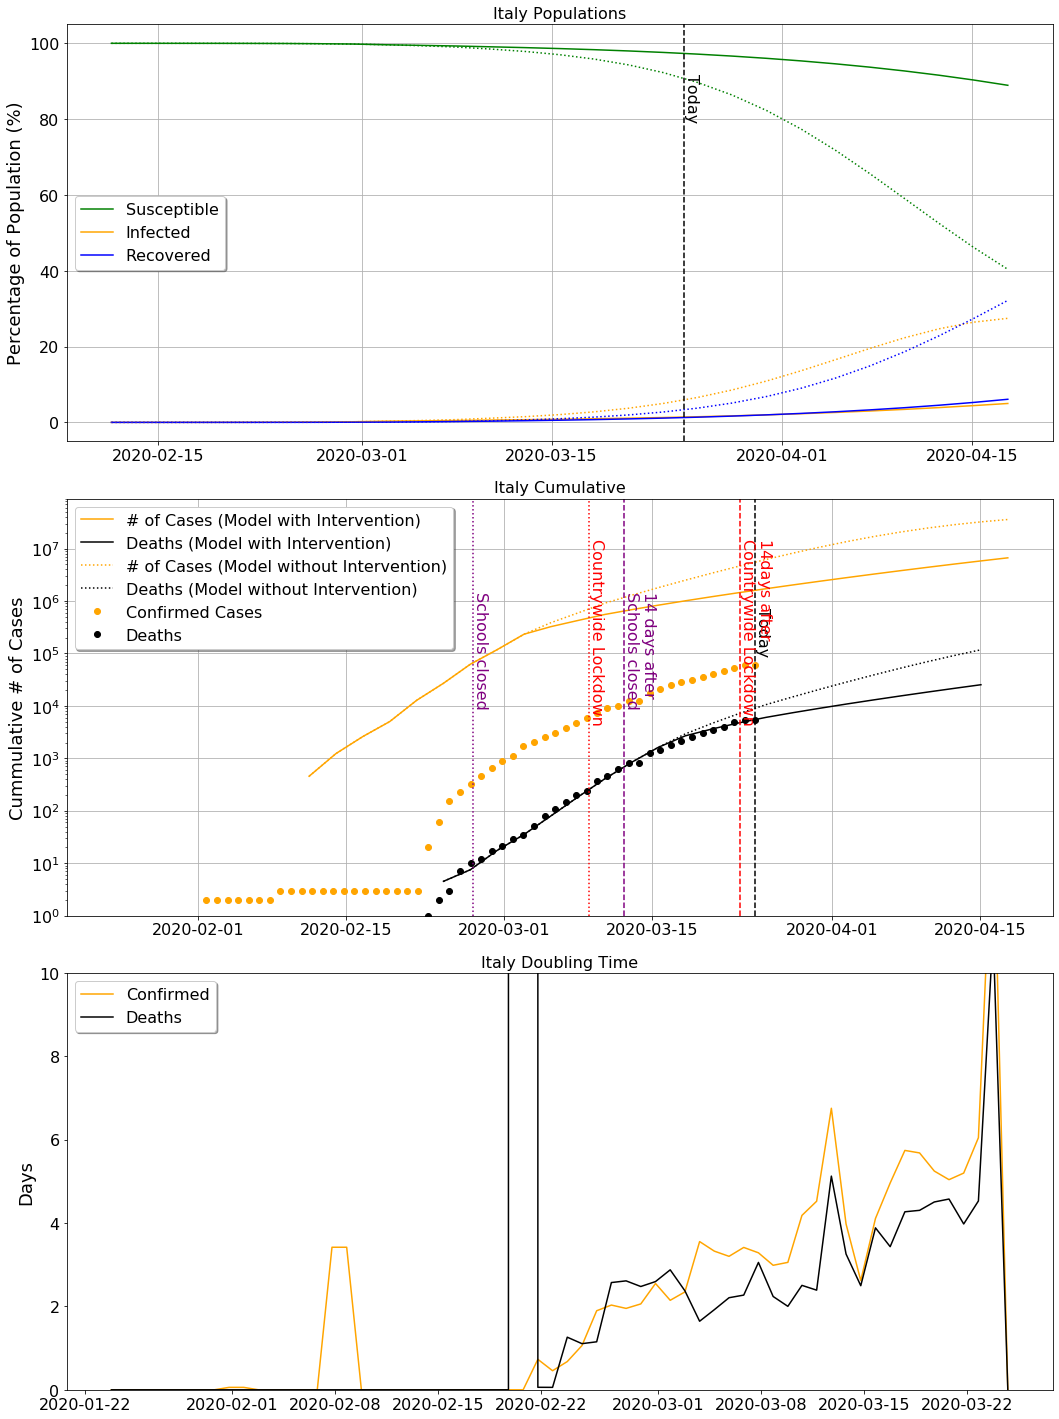

In [8]:
country = select_country('Italy')
plottage(country,RK3(country))

Parameters for: Brazil
Doubling time = 0.0  days
End of simulation at t = 22 days 

Percentage of people who avoided infection, S= 9 %
Percentage of infected, I= 48 %
Percentage of removed, R= 43 %

Percentage infected at peak of epidemics:  51 % 

Numero de mortos: 375346.0


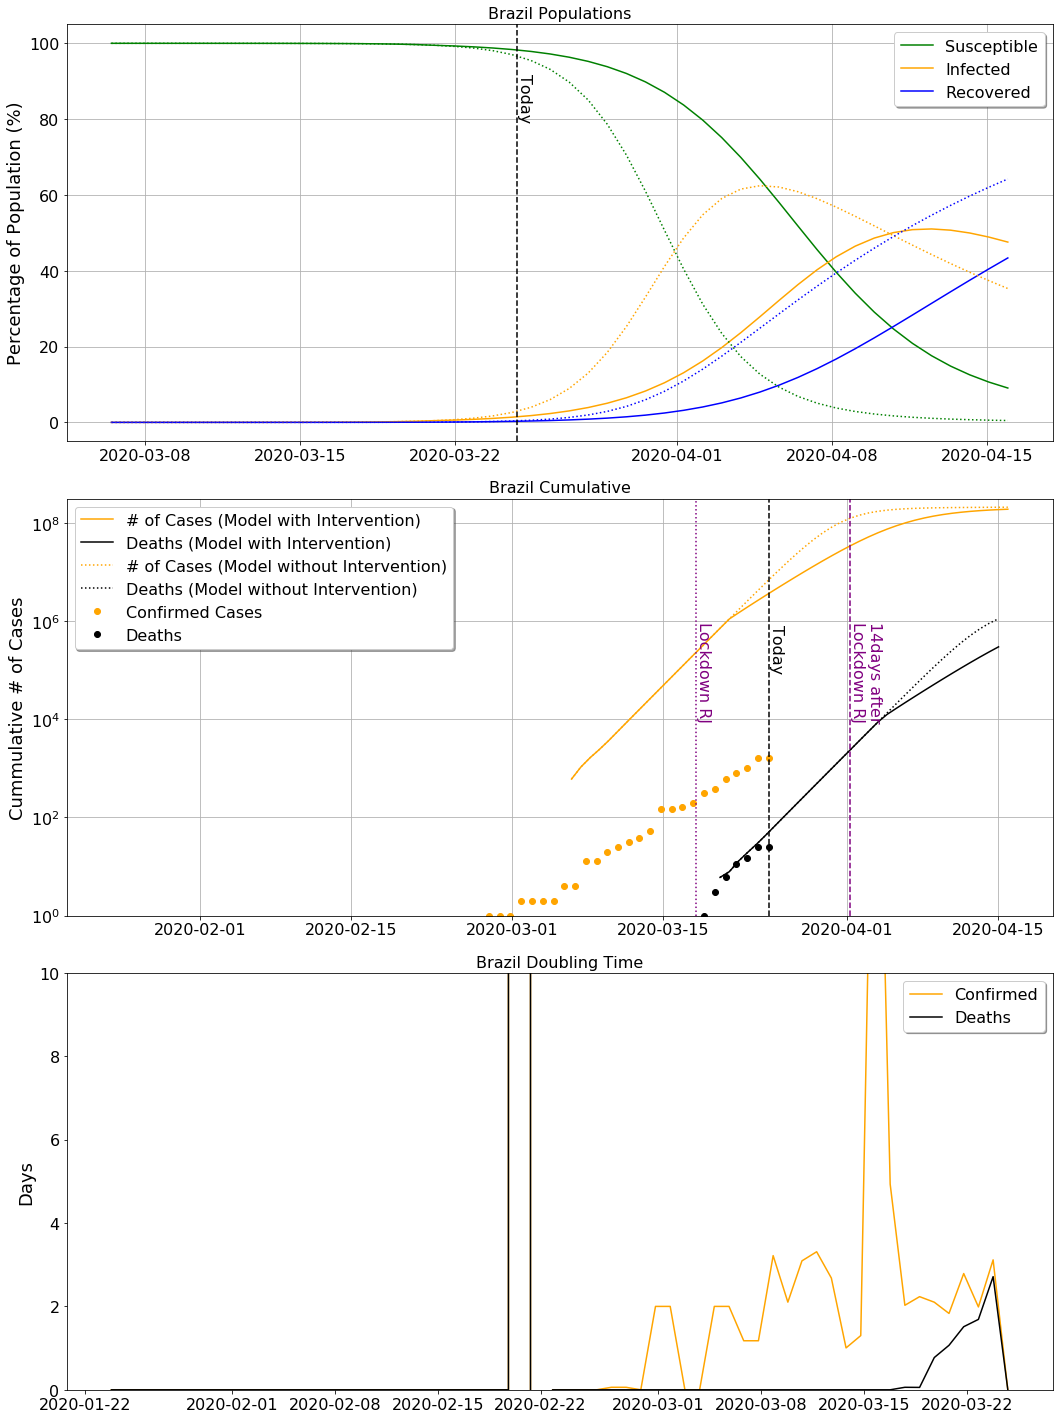

In [9]:
country = select_country('Brazil')
plottage(country,RK3(country))

In [10]:
#country = select_country('Italy')
#plottage(country,RK3(country))

#country = select_country('Korea, South')
#plottage(country,RK3(country))

In [11]:
#country = select_country('Sweden')
#plottage(country,RK3(country))

Parameters for: US
Doubling time = 5765.9448145313345  days
End of simulation at t = 22 days 

Percentage of people who avoided infection, S= 65 %
Percentage of infected, I= 23 %
Percentage of removed, R= 12 %

Percentage infected at peak of epidemics:  23 % 

Numero de mortos: 137555.0


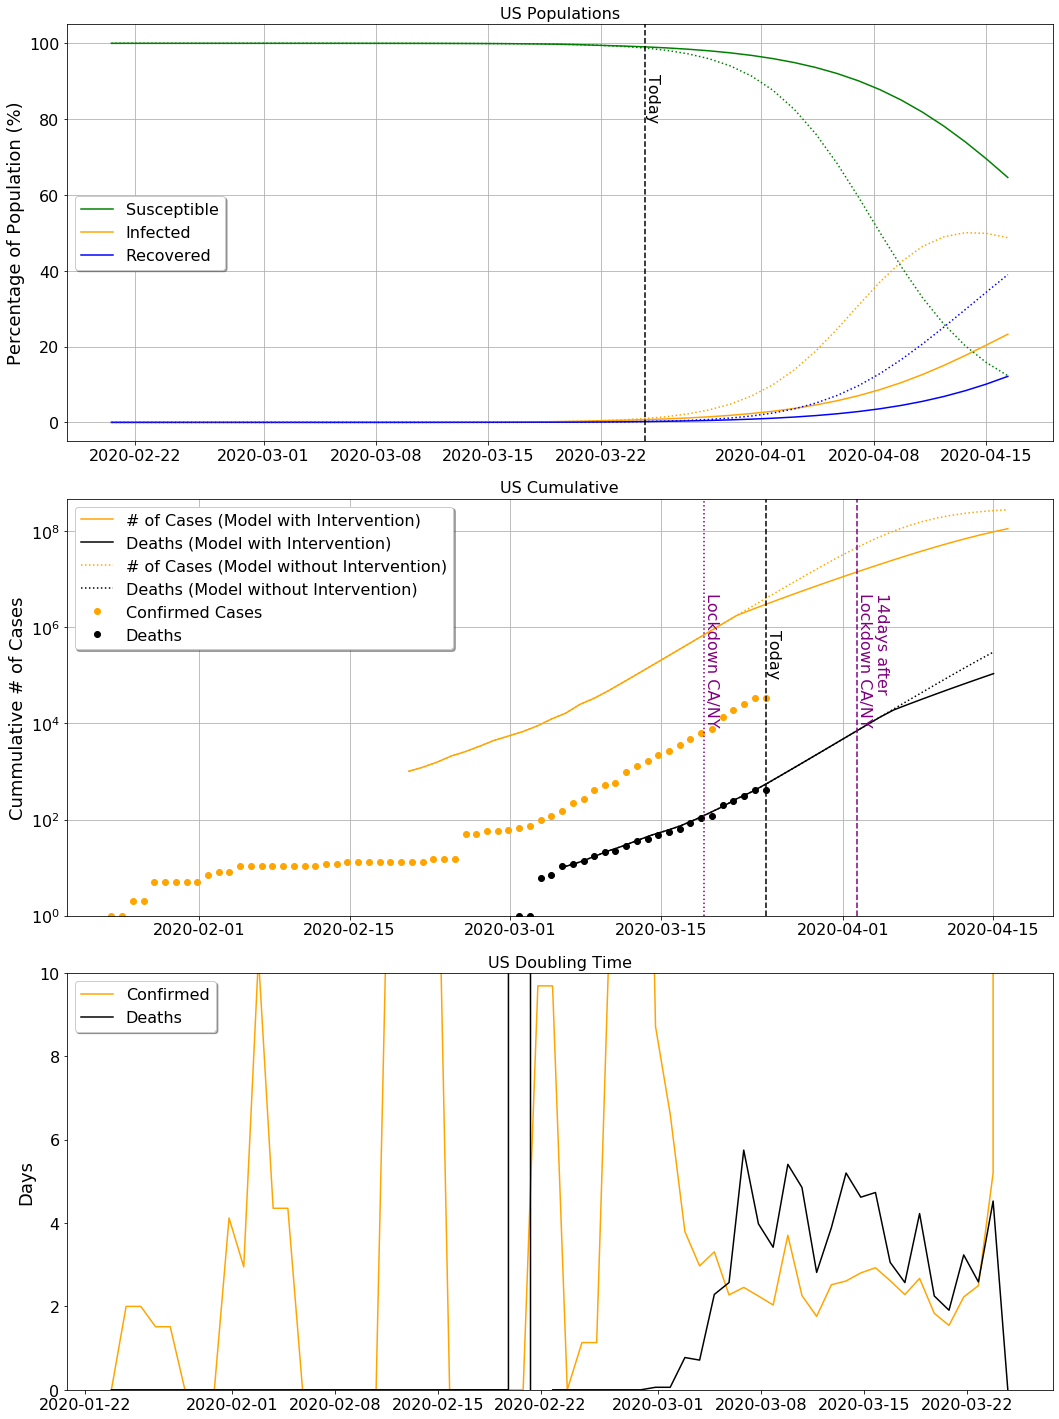

In [12]:
country = select_country('US')
plottage(country,RK3(country))

In [13]:
#country = select_country('Germany')
#plottage(country,RK3(country))

### Conclusions

This is the result of only a few hours of learning about modeling epidemiology; I do not claim the model is accurate. WHO is using a similar base model but with much more sophistication such as incubation period, transport between populations, birth and death rates, introduction of virus by the animal source, etc. For instance, $\beta$, the infection rate, depends on parameters of the population as well, like mobility. As such, it varies spatially. There's this 2D model here, applied to a city (Yerevan). 

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2

And here a 1D model solving for the populations of the animal vectors (presumably bats and including unidentified 'hosts') and people (BHRP model, for bats-hosts-reservoir-people). 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3


Still, the toy model in this notebook gives a good insight on the dynamics of the epidemics, and how social distancing works on stalling it and reducing the infection and death rate. 

# Stay home, everyone.




### References 

More on the model can be found here, and references therein. 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
    